In [1]:
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/dario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import re
from typing import Union, List

class CleanText():
    """ clearing text except digits () . , word character """ 

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text
    
def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text

clean = CleanText()


In [5]:
# label encode
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 3:
        return 1
    if x == 5 or x == 4:
        return 2
    
# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"
    

In [6]:
df = pd.read_csv("dataset.csv")

In [7]:
# show column names
print("df.columns: ", df.columns) 

df.columns:  Index(['address', 'categories', 'city', 'country', 'name', 'province',
       'reviews.rating', 'reviews.text'],
      dtype='object')


In [8]:
# head of df
df.head()

,address,categories,city,country,name,province,reviews.rating,reviews.text
0,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,4.0,Pleasant 10 min walk along the sea front to th...
1,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,Really lovely hotel. Stayed on the very top fl...
2,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,Ett mycket bra hotell. Det som drog ner betyge...
3,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,We stayed here for four nights in October. The...
4,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,We stayed here for four nights in October. The...


In [9]:
# count of ratings
fig = px.histogram(df,
             x = 'reviews.rating',
             title = 'Histogram of Review Rating',
             template = 'ggplot2',
             color = 'reviews.rating',
             color_discrete_sequence= px.colors.sequential.Blues_r,
             opacity = 0.8,
             height = 525,
             width = 835,
            )

fig.update_yaxes(title='Count')
fig.show()

In [10]:
# basic info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45912 entries, 0 to 45911
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         45912 non-null  object 
 1   categories      45912 non-null  object 
 2   city            45912 non-null  object 
 3   country         45912 non-null  object 
 4   name            45912 non-null  object 
 5   province        45912 non-null  object 
 6   reviews.rating  45050 non-null  float64
 7   reviews.text    45887 non-null  object 
dtypes: float64(1), object(7)
memory usage: 2.8+ MB


In [12]:
# encode label and mapping label name
df["label"] = df["reviews.rating"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))

In [14]:
# clean text, lowercase and remove punk
df["reviews.text"] = df["reviews.text"].apply(lambda x: str(x).lower() if isinstance(x, str) else str(x))
df["reviews.text"] = df["reviews.text"].apply(lambda x: remove_punct(clean(remove_emoji(x))[0][0]))

In [15]:
df.head()

,address,categories,city,country,name,province,reviews.rating,reviews.text,label,label_name
0,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,4.0,pleasant 10 min walk along the sea front to th...,2.0,Positive
1,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,really lovely hotel stayed on the very top fl...,2.0,Positive
2,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,ett mycket bra hotell det som drog ner betyge...,2.0,Positive
3,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,we stayed here for four nights in october the...,2.0,Positive
4,Riviera San Nicol 11/a,Hotels,Mableton,US,Hotel Russo Palace,GA,5.0,we stayed here for four nights in october the...,2.0,Positive


In [16]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

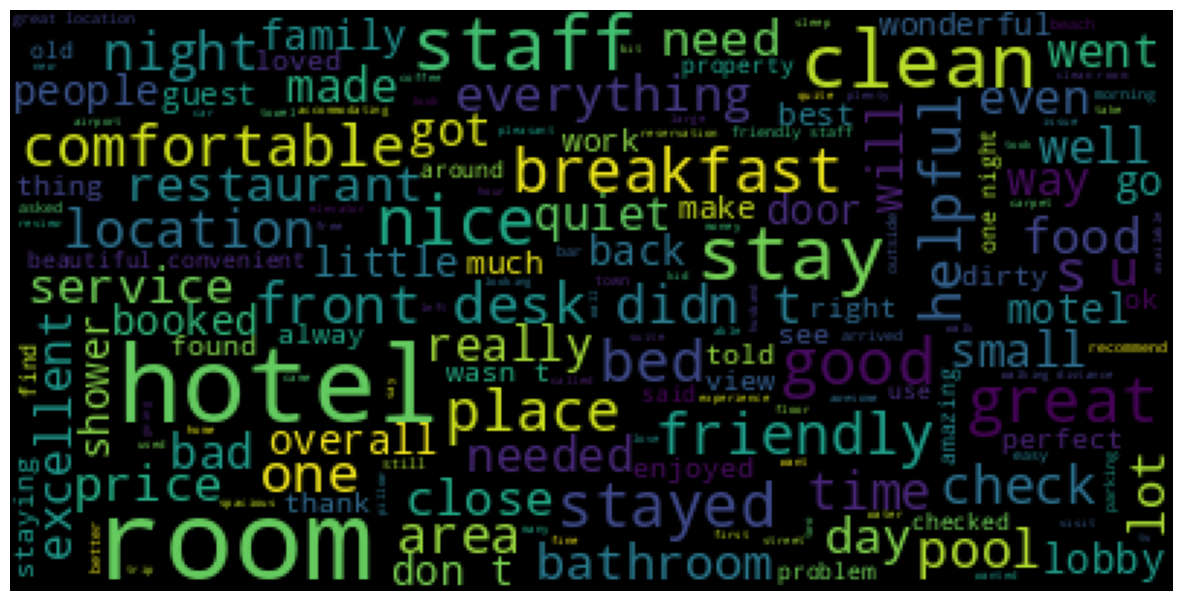

In [18]:
show_wordcloud(df["reviews.text"].values)

In [19]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig.add_trace(go.Pie(labels=df.label_name.value_counts().index,
                             values=df.label.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=df.label_name.value_counts().index, y=df.label.value_counts().values, marker_color = colors), 1,2)

fig.show()

In [23]:
# tokenize data
df["tokenized_review"] = df["reviews.text"].apply(lambda x: tokenize(x))
# calculate token count for any sent
df["sent_token_length"] = df["tokenized_review"].apply(lambda x: len(x.split()))

In [25]:
fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [26]:
(df.sent_token_length < 512).mean()

0.9995208224429343

In [28]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [29]:
# data tokenize with bert tokenizer
df["sent_bert_token_length"] = df["reviews.text"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


In [30]:
fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [31]:
# Less than 512 covers how many of the data
(df.sent_bert_token_length < 512).mean()

0.9994990416448859

In [32]:
# valvulate char count for each review
df['char_count'] = df['reviews.text'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))


    plt.suptitle(f'{title}', fontsize=24)

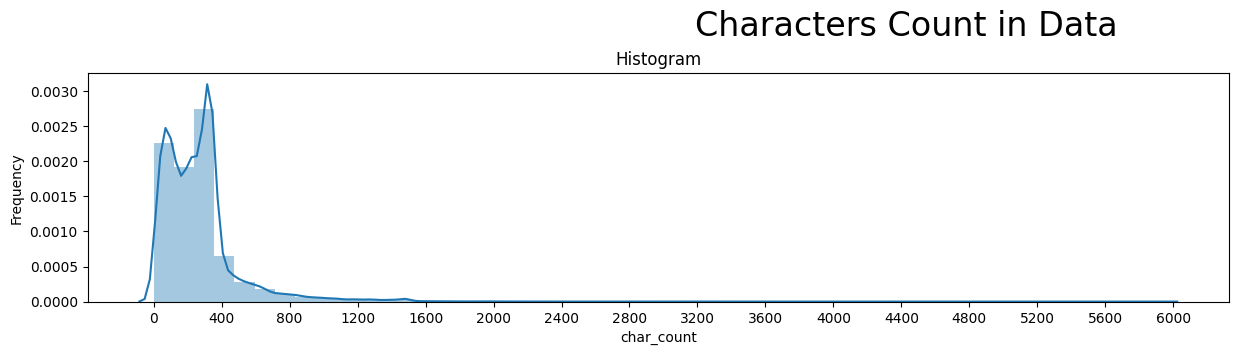

In [33]:
plot_dist3(df, 'char_count',
           'Characters Count in Data')

In [34]:
# Creating a new feature for the visualization.
df['Character Count'] = df['reviews.text'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    plt.suptitle(f'{title}', fontsize=24)

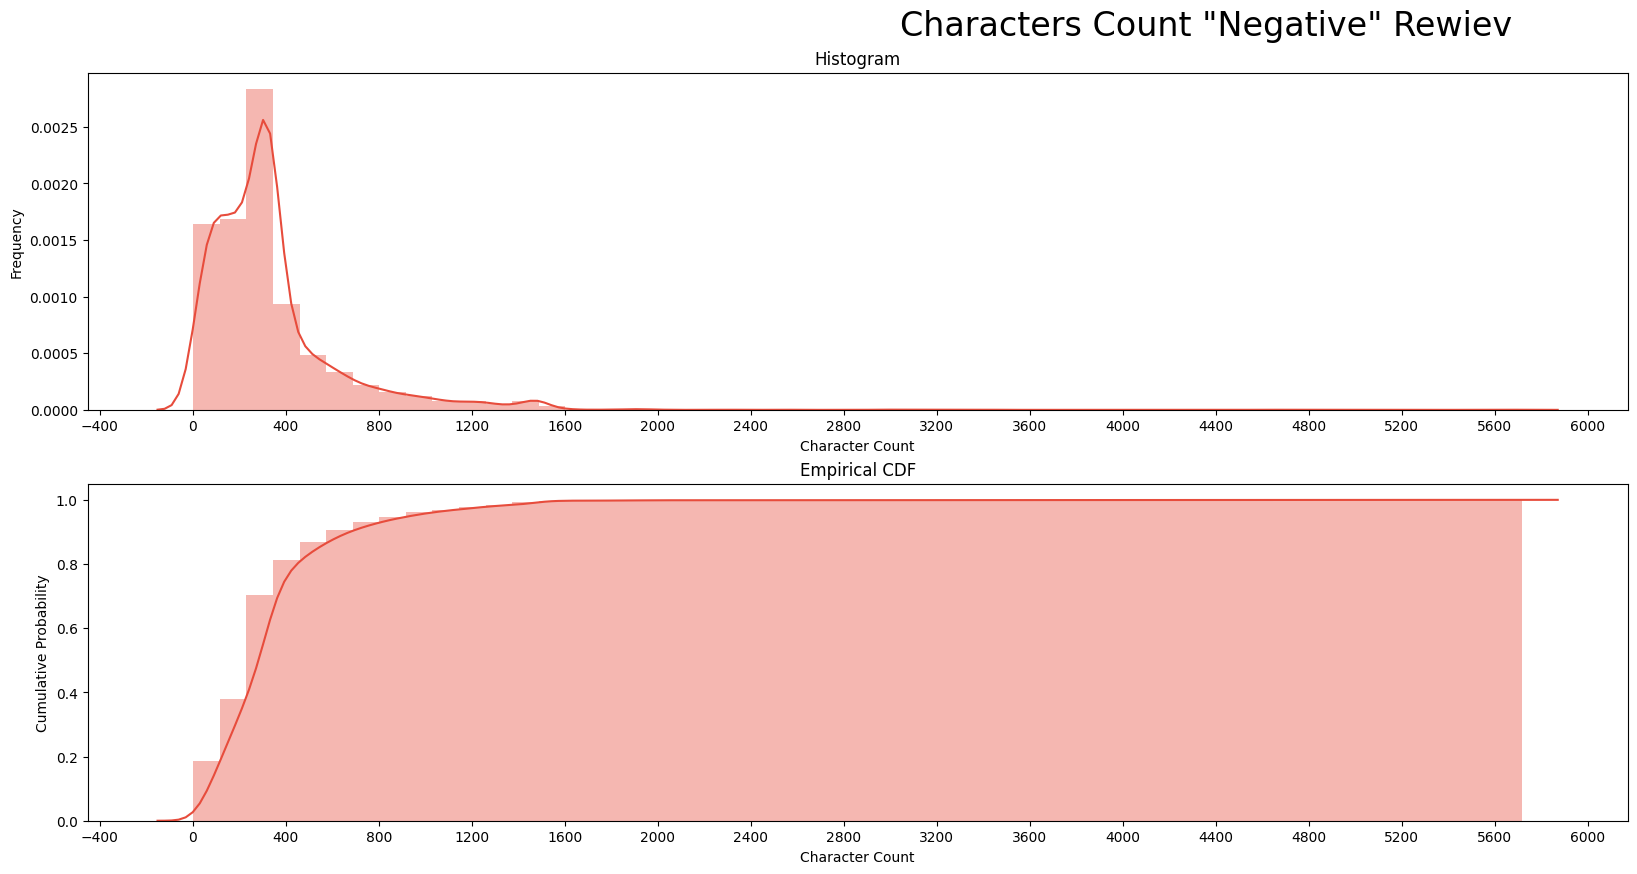

In [35]:
plot_dist3(df[df['label'] == 0], 'Character Count',
           'Characters Count "Negative" Rewiev')

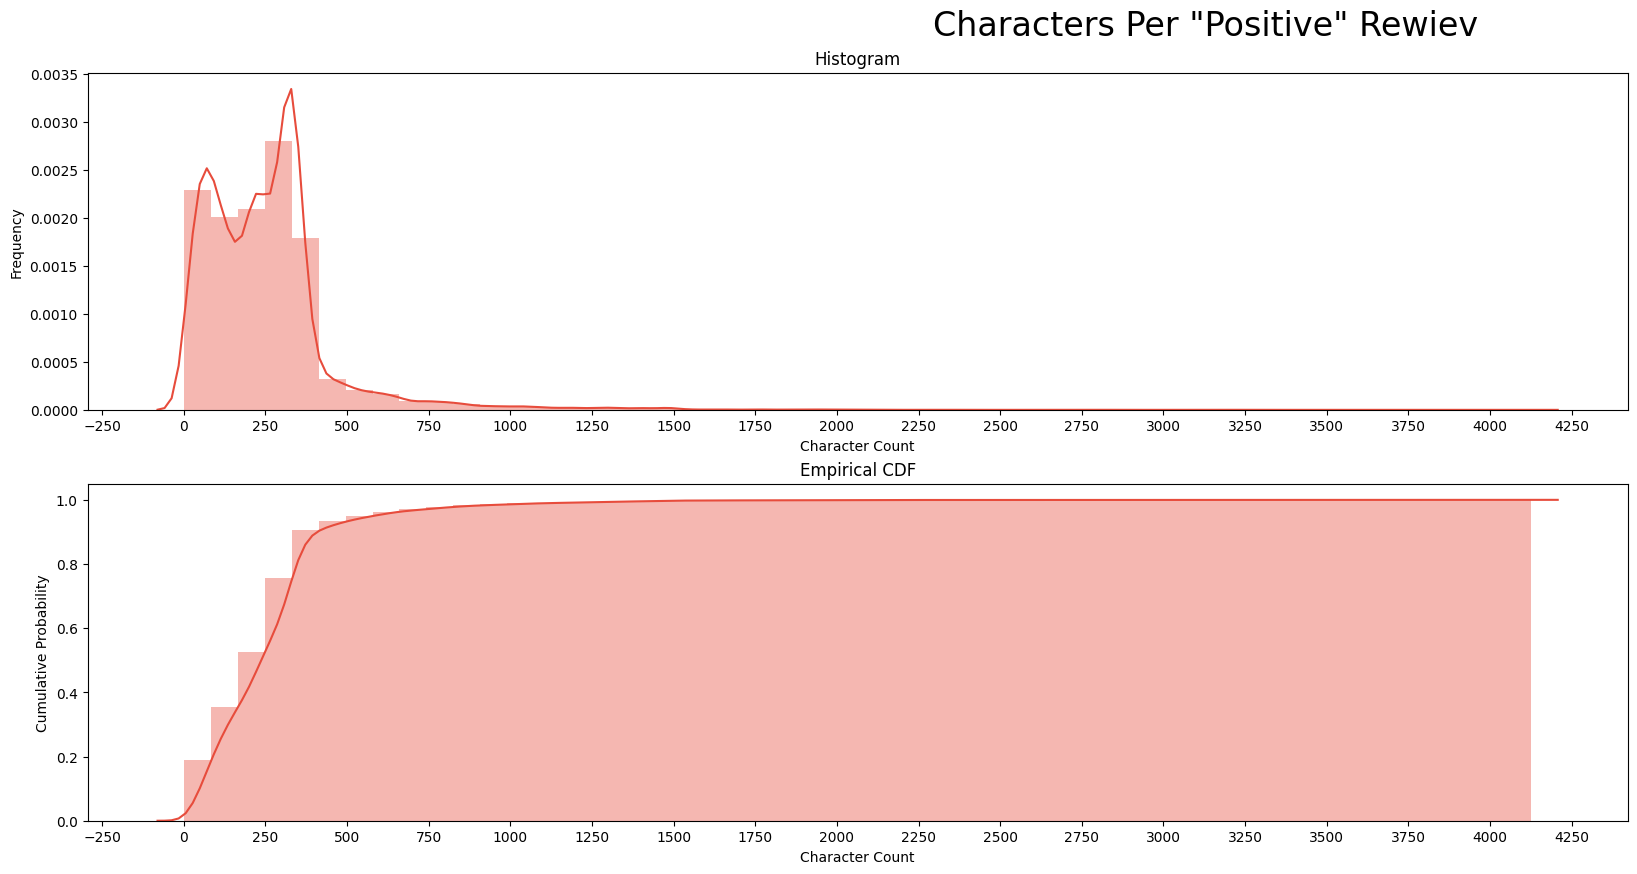

In [36]:
plot_dist3(df[df['label'] == 2], 'Character Count',
           'Characters Per "Positive" Rewiev')

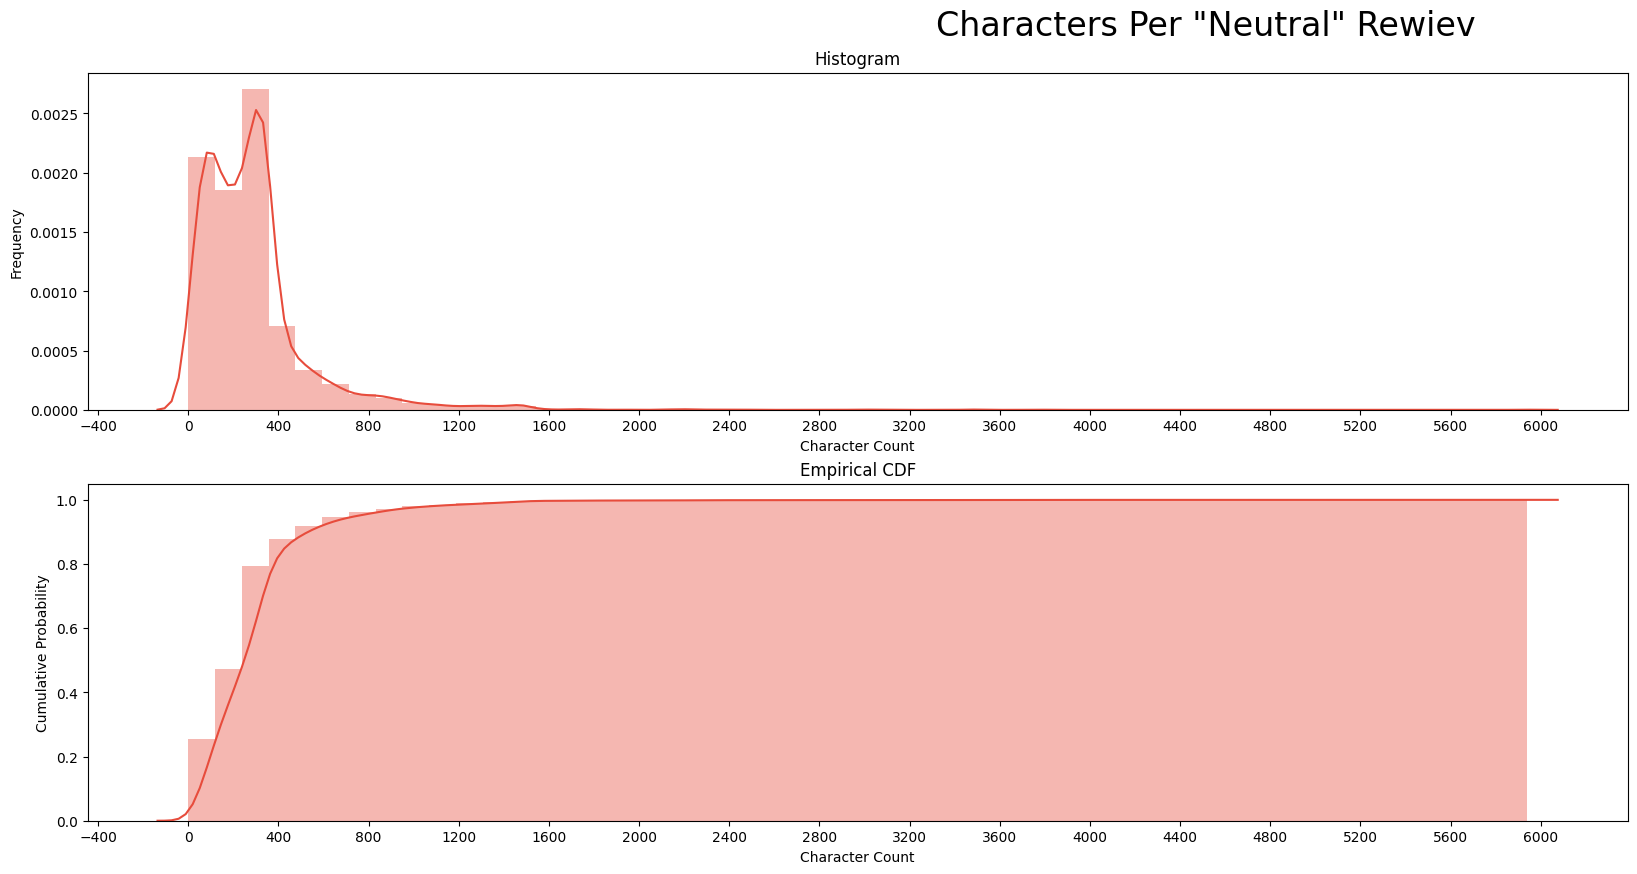

In [37]:
plot_dist3(df[df['label'] == 1], 'Character Count',
           'Characters Per "Neutral" Rewiev')

In [38]:
def plot_word_number_histogram(textno, textye, textz):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(18, 12), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    sns.distplot(textz.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')

    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('negative')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('netrual')
    axes[2].set_xlabel('Word Count')
    axes[2].set_title('pozitive')
    
    fig.suptitle('Words Per Review', fontsize=24, va='baseline')
    
    fig.tight_layout()

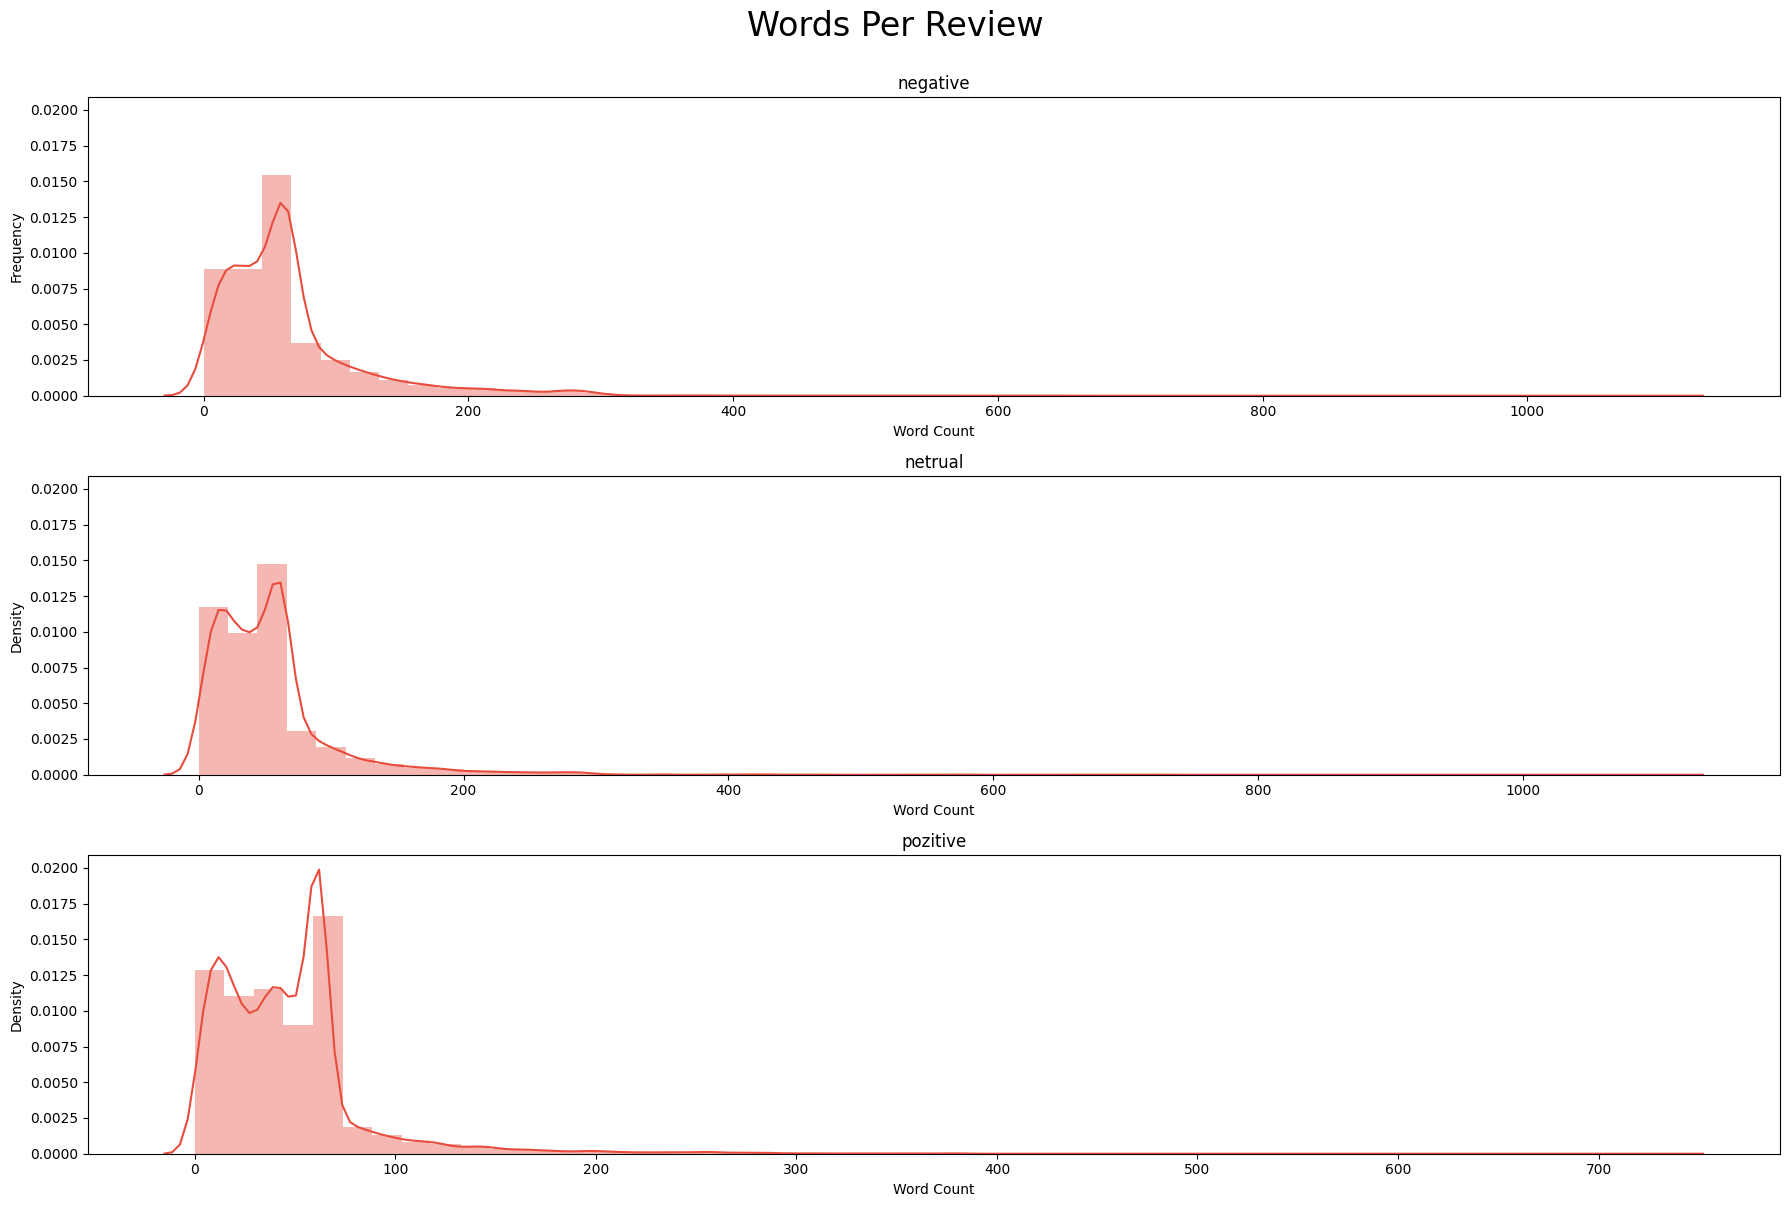

In [40]:
plot_word_number_histogram(df[df['label'] == 0]['reviews.text'],
                           df[df['label'] == 1]['reviews.text'],
                           df[df['label'] == 2]['reviews.text'],
                          )

In [42]:
# remove punk 
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: remove_punct(x))

In [43]:
texts = df['tokenized_review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

In [44]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

In [45]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [46]:
# unigram
fig = make_subplots(rows=1, cols=3)

title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common unigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))      
fig.show()

In [47]:
#trigram

fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common trigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
    
fig.show()